In [14]:

import numpy as np
from gensim.models import KeyedVectors
import gensim.downloader as api
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from tqdm import tqdm
import gensim.downloader as api
import json

model = api.load("glove-wiki-gigaword-50")
embedding_dim = model.vector_size
for word, sim in model.most_similar("cat", topn=10):
    print(f"{word:10s}  {sim:.4f}")

vec = model["dog"]
print("\n'dog' vector (first 5 dims):", vec[:5])
print("Vector shape:", vec.shape)

dog         0.9218
rabbit      0.8488
monkey      0.8041
rat         0.7892
cats        0.7865
snake       0.7799
dogs        0.7796
pet         0.7792
mouse       0.7732
bite        0.7729

'dog' vector (first 5 dims): [ 0.11008 -0.38781 -0.57615 -0.27714  0.70521]
Vector shape: (50,)


In [7]:
# vector algebra analogy: king - man + woman ≈ queen
res = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print("king - man + woman  →", res[0])

# raw embedding for 'man'
man_vec = model['man']
print("\n'vector for man' (first 5 dims):", man_vec[:5])
print("full shape:", man_vec.shape)

king - man + woman  → ('queen', 0.8523604273796082)

'vector for man' (first 5 dims): [-0.094386  0.43007  -0.17224  -0.45529   1.6447  ]
full shape: (50,)


In [3]:
!pip install torch transformers datasets tokenizers sentencepiece -q
!pip install matplotlib scikit-learn numpy -q

ERROR: Operation cancelled by user


In [8]:
ds = load_dataset("wikitext", "wikitext-2-raw-v1")
train_texts = [t for t in ds["train"]["text"] if t.strip()]
valid_texts = [t for t in ds["validation"]["text"] if t.strip()]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [9]:
print(f"Train samples: {len(train_texts)}, Valid samples: {len(valid_texts)}")

Train samples: 23767, Valid samples: 2461


In [10]:
# Tokenizer (WordLevel)
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = WordLevelTrainer(special_tokens=["[UNK]"], min_frequency=2)
tokenizer.train_from_iterator(train_texts, trainer)
print("Vocab size:", tokenizer.get_vocab_size())

Vocab size: 30000


In [11]:
# Build SkipGram dataset
class SkipGramDataset(Dataset):
    def __init__(self, texts, tokenizer, window=2):
        self.data = []
        for txt in tqdm(texts, desc="Making pairs"):
            ids = tokenizer.encode(txt).ids
            for i, tgt in enumerate(ids):
                for j in range(max(0, i-window), min(len(ids), i+window+1)):
                    if i!=j:
                        self.data.append((tgt, ids[j]))
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        return torch.tensor(self.data[i][0]), torch.tensor(self.data[i][1])

In [12]:
train_ds = SkipGramDataset(train_texts[:2000], tokenizer)
valid_ds = SkipGramDataset(valid_texts[:200], tokenizer)

Making pairs: 100%|██████████| 200/200 [00:00<00:00, 3805.63it/s]


In [17]:
# Initialize Embedding weight matrix from GloVe
vocab = tokenizer.get_vocab() # word->id
vocab_size = len(vocab)
weights = np.zeros((vocab_size, embedding_dim), np.float32)
for w, idx in vocab.items():
    weights[idx] = model[w] if w in model else np.random.normal(0, 0.6, embedding_dim)
pretrained = torch.from_numpy(weights)

In [44]:
class SkipGram(nn.Module):
    def __init__(self, pretrained_weights, freeze_emb=False):
        super().__init__()
        self.tgt_emb = nn.Embedding.from_pretrained(pretrained_weights, freeze=freeze_emb)
        self.ctx_emb = nn.Embedding.from_pretrained(pretrained_weights.clone(), freeze=freeze_emb)
    def forward(self, t, c):
        return (self.tgt_emb(t) * self.ctx_emb(c)).sum(dim=1)

In [45]:
model = SkipGram(pretrained)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SkipGram(
  (tgt_emb): Embedding(30000, 50)
  (ctx_emb): Embedding(30000, 50)
)

In [21]:
# -ve sampling
class NSLoss(nn.Module):
    def forward(self, pos, neg):
        return -torch.log(torch.sigmoid(pos)).mean() - torch.log(torch.sigmoid(-neg)).mean()

def neg_samples(bs, vocab_size, k, device):
    return torch.randint(0, vocab_size, (bs*k,), device=device)

In [22]:
def train_epoch(mdl, loader, opt, crit, vocab_size, k):
    mdl.train()
    tot=0
    for tgt, ctx in tqdm(loader, desc="Train"):
        tgt, ctx = tgt.to(device), ctx.to(device)
        opt.zero_grad()
        pos = mdl(tgt, ctx)
        bs = tgt.size(0)
        neg_ctx = neg_samples(bs, vocab_size, k, device)
        neg_tgt = tgt.repeat_interleave(k)
        neg = mdl(neg_tgt, neg_ctx)
        loss = crit(pos, neg)
        loss.backward()
        opt.step()
        tot += loss.item()
    return tot/len(loader)

In [25]:
batch_size, lr, epochs, K = 128, 1e-3, 1, 5
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
opt = optim.Adam(model.parameters(), lr=lr)
crit= NSLoss()
losses=[]
for ep in range(epochs):
    l = train_epoch(model, train_loader, opt, crit, vocab_size, K)
    losses.append(l)
    print(f"Epoch {ep+1}, Loss={l:.4f}")

Train: 100%|██████████| 5336/5336 [03:36<00:00, 24.65it/s]

Epoch 1, Loss=0.9442


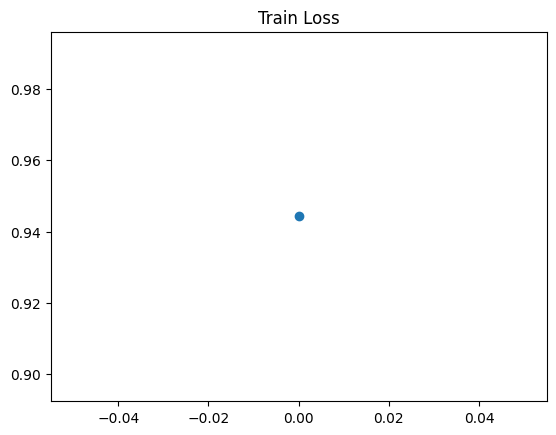

In [26]:
plt.plot(losses, marker='o'); plt.title("Train Loss"); plt.show()

In [32]:
def get_word_embedding(word, tokenizer, model):
    """Get the raw embedding vector for `word` from the target embedding."""
    # ensure CPU for .numpy()
    model.cpu()
    token_id = tokenizer.encode(word).ids[0]
    emb = model.tgt_emb.weight[token_id]
    return emb.detach().numpy()

def find_similar_words(word, tokenizer, model, top_k=5):
    """
    Find the top_k words whose embeddings
    have highest cosine similarity to `word`.
    """
    target_vec = get_word_embedding(word, tokenizer, model)
    all_embs = model.tgt_emb.weight.detach().cpu().numpy()
    # Cosine similarities
    sims = all_embs.dot(target_vec)
    sims /= (np.linalg.norm(all_embs, axis=1) * np.linalg.norm(target_vec))
    top_idxs = np.argsort(sims)[-top_k-1 : -1][::-1]
    vocab      = tokenizer.get_vocab()
    id_to_word = {idx: w for w, idx in vocab.items()}
    return [(id_to_word[idx], float(sims[idx])) for idx in top_idxs]

In [33]:
for q in ["king", "computer", "good", "bad"]:
    if q in tokenizer.get_vocab():
        sims = find_similar_words(q, tokenizer, model, top_k=5)
        print(f"\nTop neighbors of '{q}':")
        for w, score in sims:
            print(f"  {w:12s} {score:.4f}")


Top neighbors of 'king':
  prince       0.8518
  son          0.8114
  brother      0.8018
  uncle        0.7891
  father       0.7854

Top neighbors of 'computer':
  computers    0.8951
  software     0.8652
  technology   0.8489
  applications 0.7960
  devices      0.7922

Top neighbors of 'good':
  better       0.9180
  always       0.9172
  very         0.9007
  way          0.8943
  think        0.8845

Top neighbors of 'bad':
  worse        0.8756
  really       0.8399
  unfortunately 0.8133
  thing        0.8053
  too          0.8032


In [37]:
def visualize_embeddings(words, tokenizer, model, perplexity: int = 30, n_iter: int = 1000):
    """
    Visualize selected word-vectors in 2D via t-SNE.
    t-SNE (t-distributed Stochastic Neighbor Embedding) is a non-linear
    dimensionality reduction that:
     - Preserves local (neighborhood) distances
     - Converts high-D distances into probabilities
     - Minimizes the K-L divergence between high-D and low-D distributions
    """
    valid_words = [w for w in words if w in tokenizer.get_vocab()]
    if not valid_words:
        print("No valid words to visualize.")
        return

    embs = np.vstack([
        get_word_embedding(w, tokenizer, model)
        for w in valid_words
    ])
    n = embs.shape[0]

    perpl = min(perplexity, n - 1)
    if perpl < 1:
        perpl = 1

    tsne = TSNE(
        n_components=2,
        perplexity=perpl,
        n_iter=n_iter,
        random_state=42,
        init='pca'
    )
    coords = tsne.fit_transform(embs)

    plt.figure(figsize=(10, 8))
    for (x, y), w in zip(coords, valid_words):
        plt.scatter(x, y, s=50)
        plt.annotate(w, (x, y), xytext=(5,2), textcoords='offset points')
    plt.title(f"t-SNE (perplexity={perpl}, samples={n})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(alpha=0.3)
    plt.show()

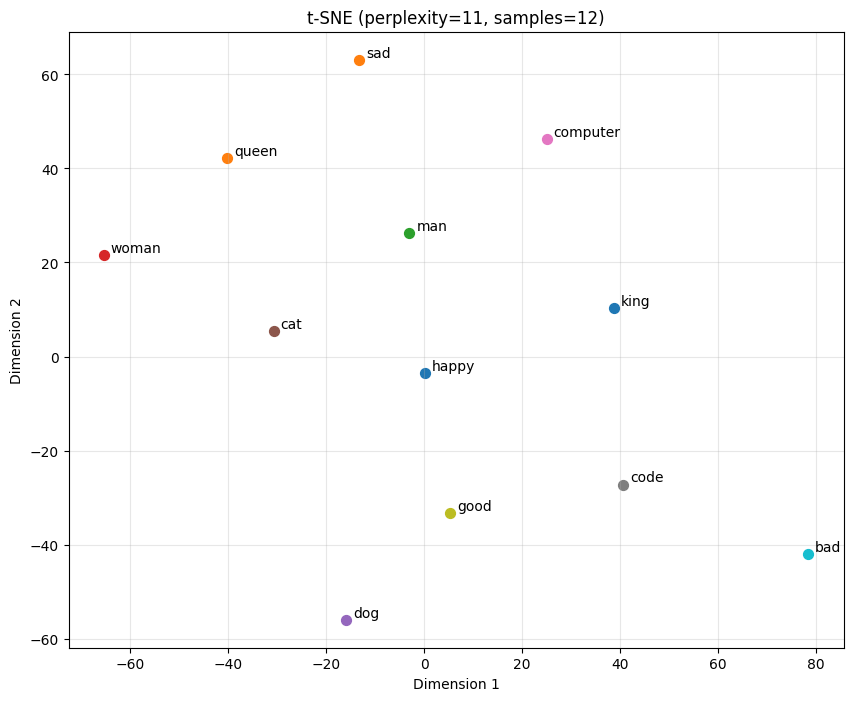

In [38]:
words_to_visualize = [
    "king","queen","man","woman","dog","cat",
    "computer","code","good","bad","happy","sad"
]
visualize_embeddings(words_to_visualize, tokenizer, model)


In [46]:
# Save embeddingGs


model.cpu()

torch.save(
    model.tgt_emb.state_dict(),
    'embeddings.pt'
)

torch.save(
    model.state_dict(),
    'skipgram_model.pt'
)

embeddings_matrix = model.tgt_emb.weight.detach().numpy()
np.save('embeddings_matrix.npy', embeddings_matrix)

vocab = tokenizer.get_vocab()
with open('vocab.json', 'w') as f:
    json.dump(vocab, f)

print("Model and embeddings saved successfully!")

Model and embeddings saved successfully!


In [50]:
# Simple Context Generator using Trained Embeddings

import torch
import torch.nn as nn
import numpy as np
import json

# Recreate the SkipGram model architecture
class SkipGram(nn.Module):
    def __init__(self, pretrained_weights, freeze_emb=False):
        super().__init__()
        self.tgt_emb = nn.Embedding.from_pretrained(pretrained_weights, freeze=freeze_emb)
        self.ctx_emb = nn.Embedding.from_pretrained(pretrained_weights.clone(), freeze=freeze_emb)

    def forward(self, tgt_ids, ctx_ids):
        return (self.tgt_emb(tgt_ids) * self.ctx_emb(ctx_ids)).sum(dim=1)

# Load vocabulary and build reverse map
with open('vocab.json','r') as f:
    vocab = json.load(f)
id_to_word = {idx: w for w, idx in vocab.items()}
vocab_size  = len(vocab)

# Load the raw embedding matrix
emb_matrix = np.load('embeddings_matrix.npy')
pretrained_weights = torch.from_numpy(emb_matrix)

# Instantiate the model and load its weights
model = SkipGram(pretrained_weights, freeze_emb=False)
model.load_state_dict(torch.load('skipgram_model.pt'))
model.eval()

# Context-generator function
def get_context_words(word: str, top_k: int = 10):
    """
    For a given `word`, returns the top_k most likely context words
    under the trained SkipGram (via sigmoid dot-product).
    """
    if word not in vocab:
        print(f"'{word}' not in vocabulary!")
        return []
    wid = vocab[word]
    tgt = torch.tensor([wid])
    all_ids = torch.arange(vocab_size)

    with torch.no_grad():
        # (1 × D) @ (V × D).T → (V,)
        scores = torch.sigmoid(
            model.tgt_emb(tgt) @ model.ctx_emb(all_ids).t()
        ).squeeze()
        # pick top_k+1 to account for the word itself
        vals, idxs = torch.topk(scores, top_k + 1)

    results = []
    for prob, idx in zip(vals.tolist(), idxs.tolist()):
        if idx == wid:
            continue
        results.append((id_to_word[idx], prob))
        if len(results) >= top_k:
            break
    return results


# Toy trained model, Tiny CONTEXT.

for query in ["king", "computer", "good", "bad", "city", "apple", "potato", "magic"]:
    print(f"\nContext words for '{query}':")
    for rank, (w, p) in enumerate(get_context_words(query, top_k=5), 1):
        print(f"  {rank}. {w:12s} {p:.4f}")


Context words for 'king':
  1. mother       1.0000
  2. son          1.0000
  3. my           1.0000
  4. army         1.0000
  5. great        1.0000

Context words for 'computer':
  1. business     1.0000
  2. system       1.0000
  3. network      1.0000
  4. information  1.0000
  5. research     1.0000

Context words for 'good':
  1. what         1.0000
  2. so           1.0000
  3. will         1.0000
  4. much         1.0000
  5. said         1.0000

Context words for 'bad':
  1. you          1.0000
  2. we           1.0000
  3. me           1.0000
  4. my           1.0000
  5. get          1.0000

Context words for 'city':
  1. they         1.0000
  2. between      1.0000
  3. 3            1.0000
  4. year         1.0000
  5. 2            1.0000

Context words for 'apple':
'apple' not in vocabulary!

Context words for 'potato':
  1. fruit        1.0000
  2. eggs         1.0000
  3. corn         1.0000
  4. cake         1.0000
  5. crops        1.0000

Context words for 'magic':
